In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import scipy.integrate as integrate

import math

import Lava as Lava

### <b> Comparison of upper surface cooling and crustal growth between Earth and Venus </b>

In [ ]:
## read in data from Flynn and Mouginins-Mark 1992
data = pd.read_csv("FlynnMougnisMark_Puuoo.csv")

t_data = data.Seconds.to_numpy()
T_data = data.Tc.to_numpy()

In [ ]:
Tlava = 1135 + 273
Ta_venus = 737 
Ta_earth = 30 + 273
Tsub_venus = Ta_venus
Tsub_earth = Ta_earth

## Thermal parameters
L = 3.2e5                 ## latent heat of fusion in J/kg; value from Wittmann et al.2017
k = 1
kappa = 5e-7

## Predefined set of lambdasfor solcing the transcendental Stefan problem
lambdas = np.arange(1.5, 0, -1e-5)

In [ ]:
## Earth
Trange = np.arange(Tlava, Ta_earth, -5)

trange_earth = np.zeros_like(Trange, dtype = np.float32)
trange_venus_noconv = np.zeros((2, len(Trange)), dtype = np.float32)
trange_venus_snyder = np.zeros_like(Trange, dtype = np.float32)

upper_crust_earth = np.zeros_like(Trange, dtype = np.float32)
upper_crust_venus_noconv = np.zeros((2, len(Trange)), dtype = np.float32)
upper_crust_venus_snyder = np.zeros_like(Trange, dtype = np.float32)

In [ ]:
l_final = 0
for i, T in enumerate(Trange):
    
    if Trange[i]==Tlava:
        trange_earth[i] = 0
        trange_venus_noconv[0,i] = 0
        trange_venus_noconv[1,i] = 0
        trange_venus_snyder[i] = 0
        
    else:
        ## Solving the Stefan problem to get lambda
        c = Lava.heat_capacity(T)
        rho = Lava.density(T)
        kappa = 1 / rho / c
        RHS = L * np.pi ** 0.5 / c / (Tlava - T)


        l = lambdas[np.argmin(np.abs(RHS - Lava.Stefan_lambda_upper_crust(lambdas)))]  


        ## Compute time at which surface temperature T is reached for Earth
        emis = 0.95
        Qrad = Lava.Radiation_flux(T, Ta_earth, emis)

        hconv = 50
        Qconv = Lava.Convection_flux(T, Ta_earth, hconv)

        t_sqroot = k * (Tlava - T) / erf(l) / (np.pi*kappa)**0.5 / (Qrad + Qconv)
        trange_earth[i] = t_sqroot**2
        upper_crust_earth[i] = Lava.crust_thickness(l, kappa, trange_earth[i])

        if T >= Ta_venus:
            ## Compute time at which surface temperature T is reached for Venus

            ## Mueller method
            emis = 0.95
            Qrad = Lava.Radiation_flux(T, Ta_venus, emis)
            Qconv1 = Lava.Convection_flux(T, Ta_venus, 1e-5)
            Qconv2 = Lava.Convection_flux(T, Ta_venus, 208)

            t_sqroot = k * (Tlava - T) / erf(l) / (np.pi*kappa)**0.5 / (Qrad + Qconv1)
            trange_venus_noconv[0,i] = t_sqroot**2
            upper_crust_venus_noconv[0, i] = Lava.crust_thickness(l, kappa, trange_venus_noconv[0,i] )
            t_sqroot = k * (Tlava - T) / erf(l) / (np.pi*kappa)**0.5 / (Qrad + Qconv2)
            trange_venus_noconv[1,i] = t_sqroot**2
            upper_crust_venus_noconv[1, i] = Lava.crust_thickness(l, kappa, trange_venus_noconv[1,i] )


            ## Flynn method
            Q_snyder = 1.07 * 1e-13 * T**4.85 * 1000                                                        ## heat flux in W/m2 using eq 8 of Flynn et al. 2023
            t_sqroot = k * (Tlava - T) / erf(l) / (np.pi*kappa)**0.5 / Q_snyder
            trange_venus_snyder[i] = t_sqroot**2
            upper_crust_venus_snyder[i] = Lava.crust_thickness(l, kappa, trange_venus_snyder[i] )
            
            l_final = l

            
        elif T < Ta_venus:
            trange_venus_noconv[0,i] = np.nan
            trange_venus_noconv[1,i] = np.nan
            trange_venus_snyder[i] = np.nan

In [ ]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12, 8)

ax.plot(trange_earth, Trange)
# ax.plot(trange_venus_noconv[0], Trange, '--')
ax.plot(trange_venus_noconv[1], Trange, '--')
ax.plot(trange_venus_snyder, Trange)
ax.scatter(t_data, T_data)
ax.semilogx()
ax.set_xlim(1e-1, 1e8)
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12, 8)

ax.plot(trange_earth, upper_crust_earth)
# ax.plot(trange_venus_noconv[0], upper_crust_venus_noconv[0], '--')
ax.plot(trange_venus_noconv[1], upper_crust_venus_noconv[1], '--')
ax.plot(trange_venus_snyder, upper_crust_venus_snyder)
# ax.scatter(t_data, T_data)
ax.semilogx()
ax.semilogy()
# ax.set_xlim(1e-1, 1e8)
plt.show()

### <b> Lava flow CAS model for a 10 m thick and 60m thick flow on Earth and Venus </b>

In [4]:
lava_thickness = [10, 60]

Tlava = 1135 + 273
Ta_venus = 737 
Ta_earth = 30 + 273
Tsub_venus = Ta_venus
Tsub_earth = Ta_earth

## Thermal parameters
L = 3.2e5                 ## latent heat of fusion in J/kg; value from Wittmann et al.2017
k = 1
kappa = 5e-7

## Predefined set of lambdasfor solcing the transcendental Stefan problem
lambdas = np.arange(1.5, 0, -1e-5)

In [ ]:
## Case 1 - Venus 10 m
lt = lava_thickness[0]
zend = -100
dz = 1e-2
z = np.arange(zend, lt, dz)
dt = 10

Tsub = Tsub_earth
Ta = Ta_earth 

T_pre_eq = np.arange(Tlava-1, Tsub, -0.5)
t_pre_eq = np.zeros_like(T_pre_eq, dtype = np.float32)
t_eq = 0
Cup_pre_eq = np.zeros_like(T_pre_eq, dtype = np.float32)
Cbase_pre_eq = np.zeros_like(T_pre_eq, dtype = np.float32)

T_up = np.zeros((len(T_pre_eq), ), dtype=np.float32)

t_surface_eq = 0
l_lower = 0
l_upper = 0

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8, 8)

for i, T in enumerate(T_pre_eq):
    c = Lava.heat_capacity(T)
    rho = Lava.density(T)
    kappa = Lava.diffusivity(1, rho, c)
    
    ################### Computation of lambda ###########################################
    # Upper crust
    RHS = L * np.pi ** 0.5 / c / (Tlava - T)
    l_up = lambdas[np.argmin(np.abs(RHS - Lava.Stefan_lambda_upper_crust(lambdas)))] 
    # Lower crust
    RHS_lower = L * np.pi ** 0.5 / c / (Tlava - Tsub)         
    l_base = lambdas[np.argmin(np.abs(RHS - Lava.Stefan_lambda_basal_crust(lambdas)))] 
    
    
    ################### Computation of fluxes and time ###################################
    # Qsnyder = Lava.Snyder_flux(T)
    Qrad = Lava.Radiation_flux(T, Ta)
    Qconv = Lava.Convection_flux(T, Ta)
    # Q = Qsnyder
    Q = Qrad + Qconv
    t = Lava.getTime(T, Tlava, Q, l_up, k, kappa)
    t_pre_eq[i] = t
    t_eq = t
    
    ################### Computation of fluxes and time ###################################
    Cbase_pre_eq[i] = Lava.crust_thickness(l_base, kappa, t)
    Cup_pre_eq[i] = Lava.crust_thickness(l_up, kappa, t)
   
    ################### Check if the lava hassolidified ##################################
    if Cup_pre_eq[i] + Cbase_pre_eq[i] >= lt:
        print("lava solidification occured at or before ", t/3600, " hours")
        break
        

    ################### Computtemperature profile in the basal crust #######################
    y_base = np.linspace(zend, Cbase_pre_eq[i], 50)
    T_base = (((Tlava-Tsub) / (erf(l_base)+1)) * (1 + erf(y_base / 2/ (kappa*t)**0.5))) + Tsub
       
    ################### Computtemperature profile in the upper crust #######################
    y_up = np.linspace(0, Cup_pre_eq[i], 50)
    T_up = (((Tlava-T) / erf(l_up)) * erf((y_up) / 2/(kappa*t)**0.5)) + T

    

    ax.plot(T_base, y_base, "--")
    ax.plot(T_up, lt-y_up)
    
    
    

    
plt.ylim(-10, lt+5)
plt.show()
print(t_eq/3600)

In [23]:
### trying a differnet algorithm

## Case 1 - Venus 10 m
lt = lava_thickness[0]
zend = -100
dz = 1e-2
z = np.arange(zend, lt, dz)
dt = 10

Tsub = Tsub_earth
Ta = Ta_earth 

T_pre_eq = np.arange(Tlava-1, Tsub, -0.5)
t_pre_eq = np.zeros_like(T_pre_eq, dtype = np.float32)
l_up_pre_eq = np.zeros_like(T_pre_eq, dtype = np.float32)
l_base_pre_eq = np.zeros_like(T_pre_eq, dtype = np.float32)

t_eq = 0.0
t_solid_near = 0.0
Cup_pre_eq = np.zeros_like(T_pre_eq, dtype = np.float32)
Cbase_pre_eq = np.zeros_like(T_pre_eq, dtype = np.float32)

T_up = np.zeros((len(T_pre_eq), ), dtype=np.float32)

l_lower = 0
l_upper = 0

for i, T in enumerate(T_pre_eq):
    c = Lava.heat_capacity(T)
    rho = Lava.density(T)
    kappa = Lava.diffusivity(1, rho, c)
    
    ################### Computation of lambda ###########################################
    # Upper crust
    RHS = L * np.pi ** 0.5 / c / (Tlava - T)
    l_up_pre_eq[i] = lambdas[np.argmin(np.abs(RHS - Lava.Stefan_lambda_upper_crust(lambdas)))] 
    # Lower crust
    RHS_lower = L * np.pi ** 0.5 / c / (Tlava - Tsub)         
    l_base_pre_eq[i] = lambdas[np.argmin(np.abs(RHS - Lava.Stefan_lambda_basal_crust(lambdas)))] 
    
    
    ################### Computation of fluxes and time ###################################
    # Qsnyder = Lava.Snyder_flux(T)
    Qrad = Lava.Radiation_flux(T, Ta)
    Qconv = Lava.Convection_flux(T, Ta)
    # Q = Qsnyder
    Q = Qrad + Qconv
    t = Lava.getTime(T, Tlava, Q, l_up, k, kappa)
    t_pre_eq[i] = t
    t_eq = t
    
    ################### Computation of fluxes and time ###################################
    Cbase_pre_eq[i] = Lava.crust_thickness(l_base_pre_eq[i], kappa, t)
    Cup_pre_eq[i] = Lava.crust_thickness(l_up_pre_eq[i], kappa, t)
    

   
    ################### Check if the lava hassolidified ##################################
    if Cup_pre_eq[i] + Cbase_pre_eq[i] >= lt:
        if t_solid_near == 0.0:
            t_solid_near = t
            print("lava solidification occured at or before ", t/3600, " hours")

lava solidification occured at or before  7289.482966903487  hours


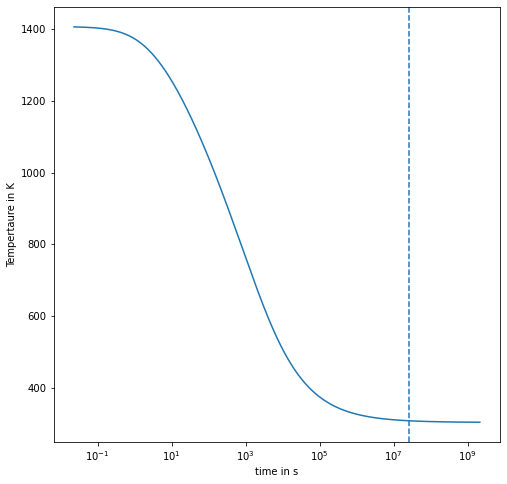

In [14]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8, 8)

ax.plot(t_pre_eq, T_pre_eq)
ax.axvline(t_solid_near, linestyle='--')
ax.semilogx()

ax.set_xlabel("time in s")
ax.set_ylabel("Tempertaure in K")
plt.show()

In [42]:
## Find time of solidification of lava has alrady solidified
if t_solid_near != 0.0:
    idx = np.where(t_pre_eq == t_solid_near)[0][0]
    tstart = t_pre_eq[idx-1]
    tstop = t_pre_eq[idx]
    interval = np.int64(tstop - tstart)
    

#     interval = np.arange(tstart, stop+1, 1)
    
#     for i in range(len(interval)):
#         t = interval[i]
#         T = 
#         kappa = 
        
        

In [29]:
idx = np.where(t_pre_eq == t_solid_near)[0][0]
l_up_pre_eq[idx-1]

0.90541

In [25]:
idx

2199